# SMS Spam Detection

In [106]:
import pandas as pd
import numpy as np
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
import string
from nltk.corpus import stopwords
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
import pickle

In [107]:
data = pd.read_csv('spam.csv')

In [108]:
data.shape

(5572, 5)

In [109]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [110]:
data.tail()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will �_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN
5571,ham,Rofl. Its true to its name,NaN,NaN,NaN


In [111]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


# 1. Data Cleaning

In [112]:
# drop last 3 cols
data.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)

In [113]:
data.sample(5)

,v1,v2
4843,spam,YOU HAVE WON! As a valued Vodafone customer ou...
370,ham,Hello my boytoy ... Geeee I miss you already a...
5275,ham,Oh yeah clearly it's my fault
4500,ham,So wat's da decision?
536,ham,"Probably gonna be here for a while, see you la..."


In [114]:
# renaming the cols
data.rename(columns={'v1':'type','v2':'sms'},inplace=True)

In [115]:
data.sample(5)

,type,sms
3537,ham,We are pleased to inform that your application...
4668,ham,"When I was born, GOD said, \Oh No! Another IDI..."
3919,spam,FREE>Ringtone! Reply REAL or POLY eg REAL1 1. ...
3322,ham,"She said,'' do u mind if I go into the bedroom..."
4593,ham,I had a good time too. Its nice to do somethin...


In [116]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [117]:
data['type']=encoder.fit_transform(data['type'])

In [118]:
data.head()

,type,sms
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [119]:
# missing values
data.isnull().sum()

type    0
sms     0
dtype: int64

In [120]:
# check for duplicate values
data.duplicated().sum()

403

In [121]:
# remove duplicates
data = data.drop_duplicates(keep='first')

In [122]:
data.duplicated().sum()

0

In [123]:
data.shape

(5169, 2)

# 2. EDA (Exploratory Data Analysis)

In [124]:
data.head()

,type,sms
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [125]:
data['type'].value_counts()

type
0    4516
1     653
Name: count, dtype: int64

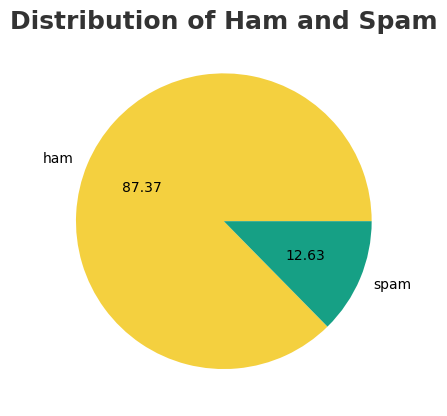

In [126]:
colors = ['#f4d03f', '#16a085']

plt.pie(data['type'].value_counts(), labels=['ham','spam'],colors=colors,autopct='%0.2f')
plt.title('Distribution of Ham and Spam', fontsize=18, color='#333333', weight='bold')
plt.show()


# Data is imbalanced

In [127]:
data['sms_characters_len']=data['sms'].apply(len)

In [128]:
data.head()

,type,sms,sms_characters_len
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [129]:
# num of words
data['sms'].apply(lambda x:nltk.word_tokenize(x))

0       [Go, until, jurong, point, ,, crazy, .., Avail...
1                [Ok, lar, ..., Joking, wif, u, oni, ...]
2       [Free, entry, in, 2, a, wkly, comp, to, win, F...
3       [U, dun, say, so, early, hor, ..., U, c, alrea...
4       [Nah, I, do, n't, think, he, goes, to, usf, ,,...
                              ...                        
5567    [This, is, the, 2nd, time, we, have, tried, 2,...
5568     [Will, �_, b, going, to, esplanade, fr, home, ?]
5569    [Pity, ,, *, was, in, mood, for, that, ., So, ...
5570    [The, guy, did, some, bitching, but, I, acted,...
5571                  [Rofl, ., Its, true, to, its, name]
Name: sms, Length: 5169, dtype: object

In [130]:
data['num_words']=data['sms'].apply(lambda x:len(nltk.word_tokenize(x)))

In [131]:
data.head()

,type,sms,sms_characters_len,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


In [132]:
data['sms'].apply(lambda x:nltk.sent_tokenize(x))

0       [Go until jurong point, crazy.., Available onl...
1                        [Ok lar..., Joking wif u oni...]
2       [Free entry in 2 a wkly comp to win FA Cup fin...
3       [U dun say so early hor... U c already then sa...
4       [Nah I don't think he goes to usf, he lives ar...
                              ...                        
5567    [This is the 2nd time we have tried 2 contact ...
5568              [Will �_ b going to esplanade fr home?]
5569    [Pity, * was in mood for that., So...any other...
5570    [The guy did some bitching but I acted like i'...
5571                        [Rofl., Its true to its name]
Name: sms, Length: 5169, dtype: object

In [133]:
data['num_sentences']=data['sms'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [134]:
data.head()

,type,sms,sms_characters_len,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [135]:
data[['sms_characters_len','num_words','num_sentences']].describe()

,sms_characters_len,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.924163,18.456761,1.966531
std,58.175349,13.325633,1.449833
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [136]:
# ham messages
data[data['type']==0][['sms_characters_len','num_words','num_sentences']].describe()

,sms_characters_len,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.457263,17.123782,1.820195
std,56.357463,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [137]:
# spam messages
data[data['type']==1][['sms_characters_len','num_words','num_sentences']].describe()

,sms_characters_len,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.479326,27.675345,2.978560
std,30.014336,7.011513,1.493185
min,13.000000,2.000000,1.000000
25%,131.000000,25.000000,2.000000
50%,148.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,223.000000,46.000000,9.000000


<Axes: xlabel='sms_characters_len', ylabel='Count'>

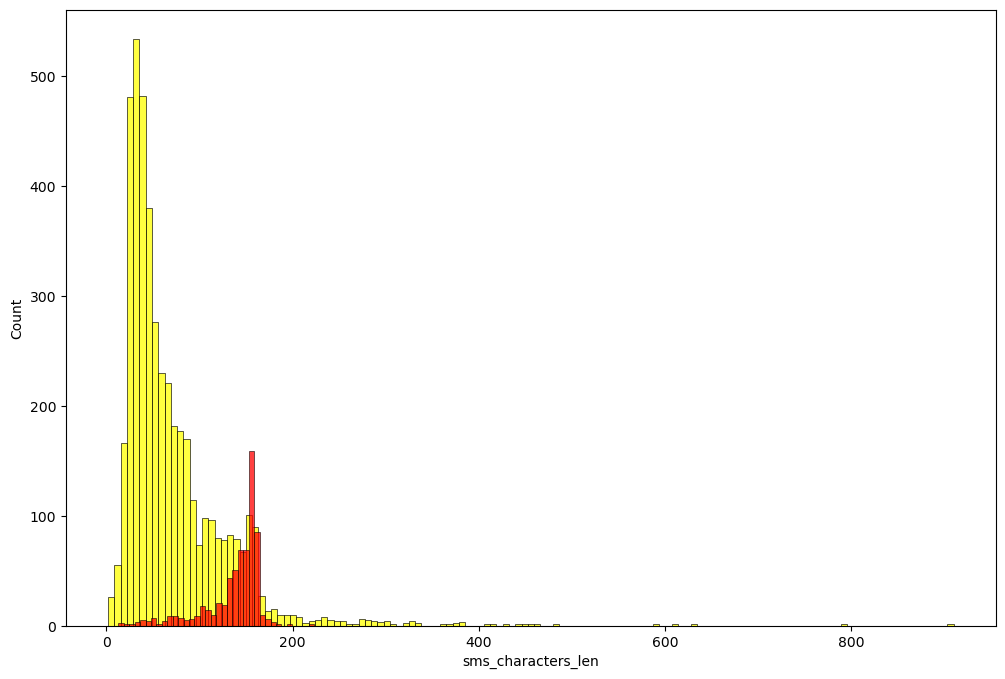

In [138]:
plt.figure(figsize=(12,8))
sns.histplot(data[data['type']==0]['sms_characters_len'],color='yellow')
sns.histplot(data[data['type']==1]['sms_characters_len'],color='red')

<Axes: xlabel='num_words', ylabel='Count'>

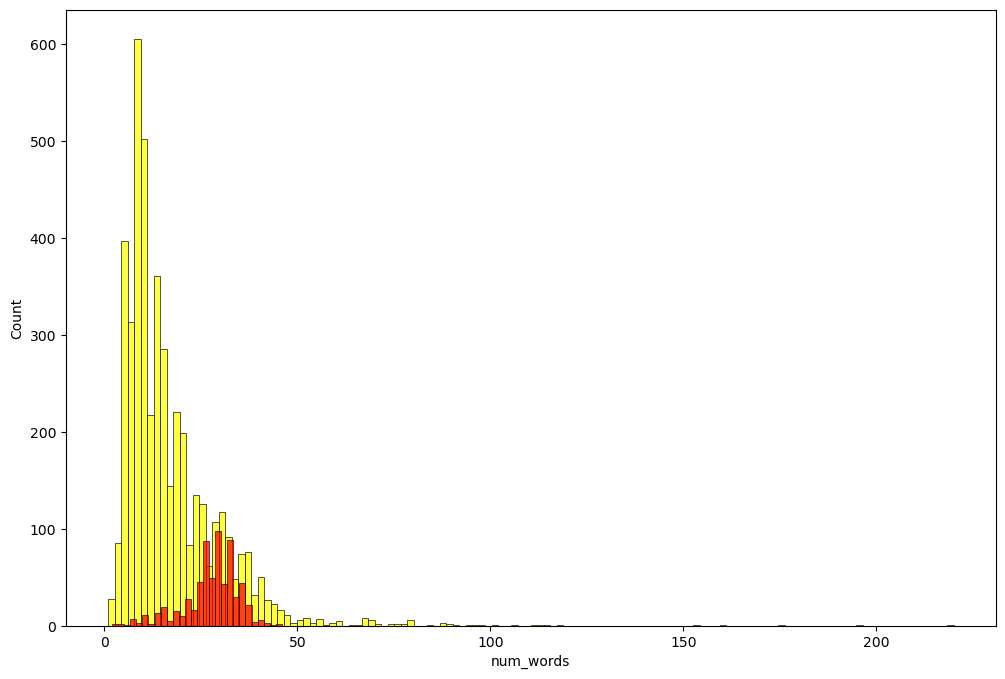

In [139]:
plt.figure(figsize=(12,8))
sns.histplot(data[data['type']==0]['num_words'],color='yellow')
sns.histplot(data[data['type']==1]['num_words'],color='red')

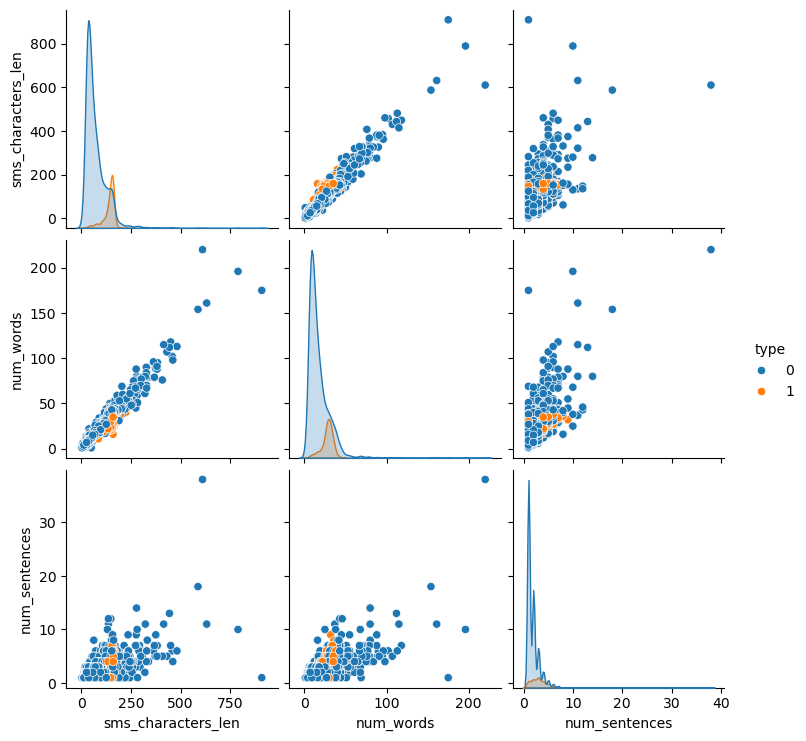

In [140]:
sns.pairplot(data,hue='type')

<Axes: >

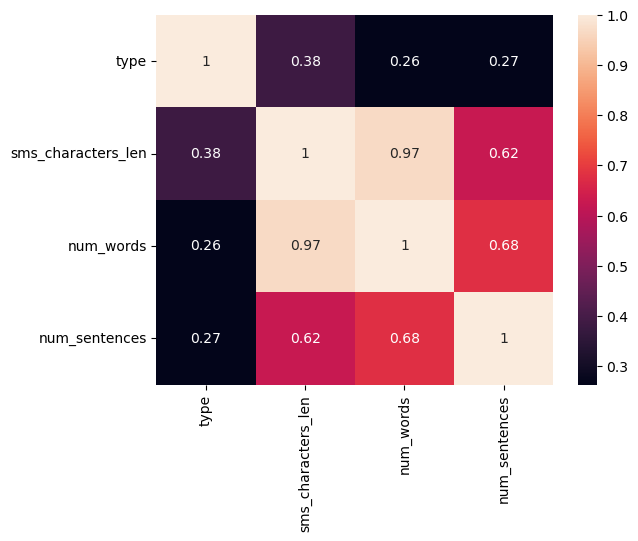

In [141]:
corr = data.corr(numeric_only=True)
sns.heatmap(corr,annot=True)

# 3. Data Preprocessing

In [142]:
ps = PorterStemmer()

In [151]:
def transform_text(sms):
    sms = sms.lower()
    sms = nltk.word_tokenize(sms)
    
    y = []
    for i  in sms:
        if i.isalnum():
            y.append(i)

    sms = y[:]
    y.clear()

    for i in sms:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    sms = y[:]
    y.clear()

    for i in sms:
        y.append(ps.stem(i))
        
      
    return " ".join(y)

In [144]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [145]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [152]:
transform_text('I loved the youtube lectures on Machine Leraning. How about you?')

'love youtub lectur machin leran'

In [153]:
ps.stem('loving')

'love'

In [154]:
data['sms'][10]

"I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today."

In [155]:
transform_text("I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.")

'gon na home soon want talk stuff anymor tonight k cri enough today'

In [156]:
data['sms'].apply(transform_text)

0       go jurong point crazi avail bugi n great world...
1                                   ok lar joke wif u oni
2       free entri 2 wkli comp win fa cup final tkt 21...
3                     u dun say earli hor u c alreadi say
4                    nah think goe usf live around though
                              ...                        
5567    2nd time tri 2 contact u pound prize 2 claim e...
5568                                b go esplanad fr home
5569                                    piti mood suggest
5570    guy bitch act like interest buy someth els nex...
5571                                       rofl true name
Name: sms, Length: 5169, dtype: object

In [160]:
data['transformed_sms'] = data['sms'].apply(transform_text)

In [161]:
data.head()

,type,sms,sms_characters_len,num_words,num_sentences,transformed_sms
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [162]:
from wordcloud import WordCloud
wc = WordCloud(width=500,height=500,min_font_size=10,background_color = 'white')

In [163]:
spam_wc=wc.generate(data[data['type'] == 1]['transformed_sms'].str.cat(sep=" "))

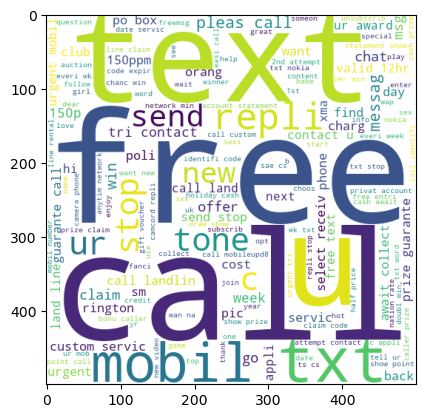

In [164]:
plt.imshow(spam_wc)

In [165]:
ham_wc=wc.generate(data[data['type'] == 0]['transformed_sms'].str.cat(sep=" "))

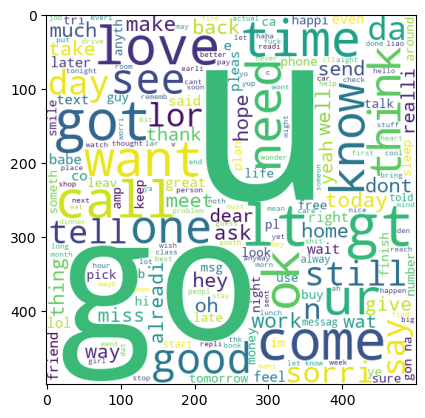

In [166]:
plt.imshow(ham_wc)

In [167]:
spam_corpus = []
for msg in data[data['type'] == 1]['transformed_sms'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

In [168]:
len(spam_corpus)

9941

C:\Users\sriha\AppData\Local\Temp\ipykernel_6656\2554991638.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='word', y='count', data=spam_common, palette=palette)


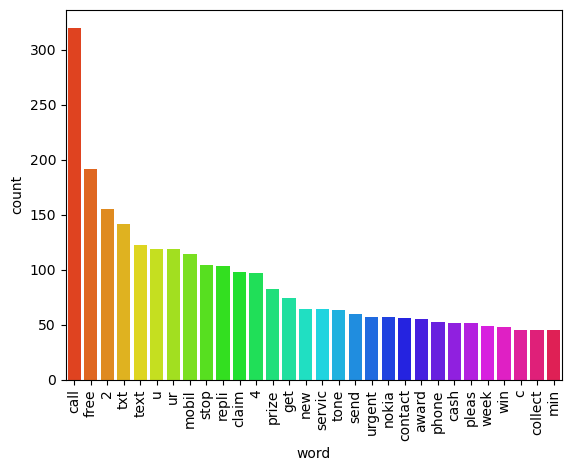

In [169]:
spam_common = pd.DataFrame(Counter(spam_corpus).most_common(30), columns=['word', 'count'])
palette = sns.color_palette("hsv", n_colors=30)
sns.barplot(x='word', y='count', data=spam_common, palette=palette)
plt.xticks(rotation='vertical')
plt.show()

In [170]:
ham_corpus = []
for msg in data[data['type'] == 0]['transformed_sms'].tolist():
    for word in msg.split():
        ham_corpus.append(word)

In [171]:
len(ham_corpus)

35305

C:\Users\sriha\AppData\Local\Temp\ipykernel_6656\292180071.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='word', y='count', data=ham_common, palette=palette)


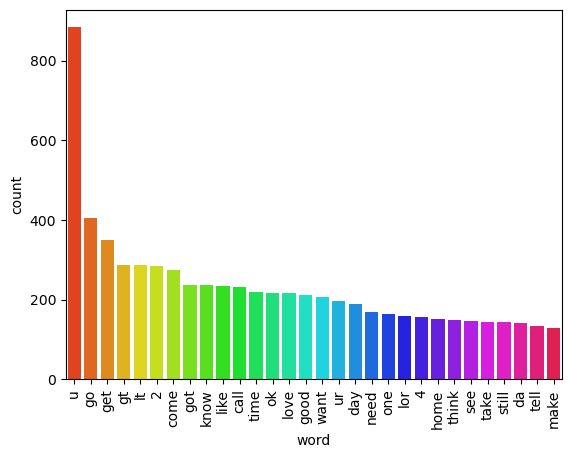

In [172]:
ham_common = pd.DataFrame(Counter(ham_corpus).most_common(30), columns=['word', 'count'])
palette = sns.color_palette("hsv", n_colors=30)
sns.barplot(x='word', y='count', data=ham_common, palette=palette)
plt.xticks(rotation='vertical')
plt.show()

# 4. Model Building

In [173]:
# cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=3000)

In [174]:
# x = cv.fit_transform(data['transformed_sms']).toarray()
X = tfidf.fit_transform(data['transformed_sms']).toarray() 

In [175]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [176]:
Y = data['type'].values

In [177]:
Y

array([0, 0, 1, ..., 0, 0, 0])

In [178]:
# x_train,x_test,Y_train,Y_test = train_test_split(x,Y,test_size=0.2,random_state=2)

In [179]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=2)

In [180]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()
svc = SVC(kernel='sigmoid',gamma=1.0)
knc = KNeighborsClassifier()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50, random_state=2)
xgb = XGBClassifier(n_estimators=50, random_state=2)

In [181]:
# # CountVectorizer
# gnb.fit(x_train,Y_train)
# Y_pred1 = gnb.predict(x_test)
# print(accuracy_score(Y_test,Y_pred1))
# print(confusion_matrix(Y_test,Y_pred1))
# print(precision_score(Y_test,Y_pred1))

In [182]:
# TfidfVectorizer
gnb.fit(X_train,Y_train)
Y_pred4 = gnb.predict(X_test)
print(accuracy_score(Y_test,Y_pred4))
print(confusion_matrix(Y_test,Y_pred4))
print(precision_score(Y_test,Y_pred4))

0.8723404255319149
[[782 114]
 [ 18 120]]
0.5128205128205128


In [183]:
# # CountVectorizer
# mnb.fit(x_train,Y_train)
# Y_pred2 = mnb.predict(x_test)
# print(accuracy_score(Y_test,Y_pred2))
# print(confusion_matrix(Y_test,Y_pred2))
# print(precision_score(Y_test,Y_pred2))

In [184]:
# TfidfVectorizer
mnb.fit(X_train,Y_train)
Y_pred5 = mnb.predict(X_test)
print(accuracy_score(Y_test,Y_pred5))
print(confusion_matrix(Y_test,Y_pred5))
print(precision_score(Y_test,Y_pred5))

0.9787234042553191
[[889   7]
 [ 15 123]]
0.9461538461538461


In [185]:
# # CountVectorizer
# bnb.fit(x_train,Y_train)
# Y_pred3 = bnb.predict(x_test)
# print(accuracy_score(Y_test,Y_pred3))
# print(confusion_matrix(Y_test,Y_pred3))
# print(precision_score(Y_test,Y_pred3))

In [186]:
# TfidfVectorizer
bnb.fit(X_train,Y_train)
Y_pred6 = bnb.predict(X_test)
print(accuracy_score(Y_test,Y_pred6))
print(confusion_matrix(Y_test,Y_pred6))
print(precision_score(Y_test,Y_pred6))

0.9835589941972921
[[895   1]
 [ 16 122]]
0.991869918699187


In [187]:
clfs = {
    'SVC' : svc,
    'KN' : knc,
    'NB' : mnb,
    'DT' : dtc,
    'LR' : lrc,
    'RF' : rfc,
    'AdaBoost' : abc,
    'BgC' : bc,
    'ETC' : etc,
    'GBDT' : gbdt,
    'xgb' : xgb
}

In [188]:
def train_classifier(clf,X_train,Y_train,X_test,Y_test):
    clf.fit(X_train ,Y_train)
    Y_pred = clf.predict(X_test)
    accuracy = accuracy_score(Y_test,Y_pred)
    precision = precision_score(Y_test,Y_pred)

    return accuracy,precision

In [189]:
train_classifier(svc,X_train,Y_train,X_test,Y_test)

(0.9729206963249516, 0.9508196721311475)

In [190]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():
    current_accuracy,current_precision = train_classifier(clf , X_train ,Y_train, X_test , Y_test)

    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)

    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For  SVC
Accuracy -  0.9729206963249516
Precision -  0.9508196721311475
For  KN
Accuracy -  0.9052224371373307
Precision -  0.9761904761904762
For  NB
Accuracy -  0.9787234042553191
Precision -  0.9461538461538461
For  DT
Accuracy -  0.9332688588007737
Precision -  0.8415841584158416
For  LR
Accuracy -  0.9671179883945842
Precision -  0.9642857142857143
For  RF
Accuracy -  0.9748549323017408
Precision -  0.9827586206896551
For  AdaBoost
Accuracy -  0.9613152804642167
Precision -  0.9454545454545454
For  BgC
Accuracy -  0.9593810444874274
Precision -  0.8692307692307693
For  ETC
Accuracy -  0.9796905222437138
Precision -  0.975609756097561
For  GBDT
Accuracy -  0.9468085106382979
Precision -  0.9278350515463918
For  xgb
Accuracy -  0.9680851063829787
Precision -  0.9411764705882353


# 5. Model Evaluation

In [191]:
performance_data = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)

In [192]:
performance_data

,Algorithm,Accuracy,Precision
5,RF,0.974855,0.982759
1,KN,0.905222,0.976190
8,ETC,0.979691,0.975610
4,LR,0.967118,0.964286
0,SVC,0.972921,0.950820
2,NB,0.978723,0.946154
6,AdaBoost,0.961315,0.945455
10,xgb,0.968085,0.941176
9,GBDT,0.946809,0.927835
7,BgC,0.959381,0.869231


In [193]:
performance_data1 = pd.melt(performance_data, id_vars = "Algorithm")

In [194]:
performance_data1 

,Algorithm,variable,value
0,RF,Accuracy,0.974855
1,KN,Accuracy,0.905222
2,ETC,Accuracy,0.979691
3,LR,Accuracy,0.967118
4,SVC,Accuracy,0.972921
5,NB,Accuracy,0.978723
6,AdaBoost,Accuracy,0.961315
7,xgb,Accuracy,0.968085
8,GBDT,Accuracy,0.946809
9,BgC,Accuracy,0.959381


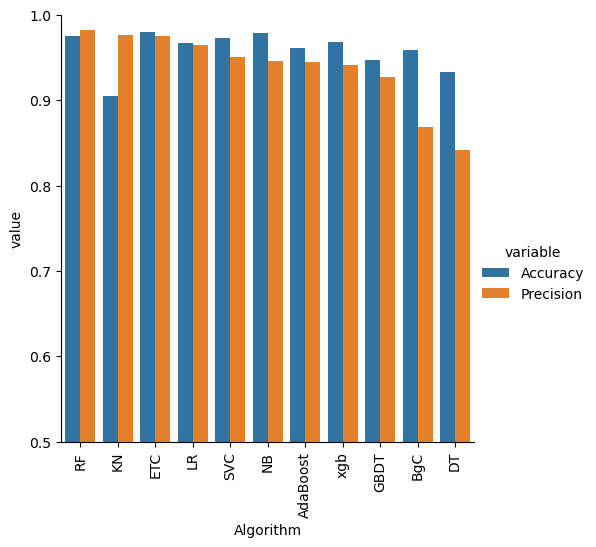

In [195]:
sns.catplot(x = 'Algorithm', y='value', 
               hue = 'variable',data=performance_data1, kind='bar',height=5)
plt.ylim(0.5,1.0)
plt.xticks(rotation='vertical')
plt.show()

# 6. Model Improvement

In [196]:
# changing the max_features paramater of TfIdf

In [197]:
temp_data = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy_max_ft_3000':accuracy_scores,'Precision_max_ft_3000':precision_scores}).sort_values('Precision_max_ft_3000',ascending=False)

In [198]:
temp_data = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy_scaling':accuracy_scores,'Precision_scaling':precision_scores}).sort_values('Precision_scaling',ascending=False)

In [199]:
new_data = performance_data.merge(temp_data,on='Algorithm')

In [200]:
new_data_scaled = new_data.merge(temp_data,on='Algorithm')

In [201]:
temp_data = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy_num_chars':accuracy_scores,'Precision_num_chars':precision_scores}).sort_values('Precision_num_chars',ascending=False)

In [202]:
new_data_scaled.merge(temp_data,on='Algorithm')

,Algorithm,Accuracy,Precision,Accuracy_scaling_x,Precision_scaling_x,Accuracy_scaling_y,Precision_scaling_y,Accuracy_num_chars,Precision_num_chars
0,RF,0.974855,0.982759,0.974855,0.982759,0.974855,0.982759,0.974855,0.982759
1,KN,0.905222,0.976190,0.905222,0.976190,0.905222,0.976190,0.905222,0.976190
2,ETC,0.979691,0.975610,0.979691,0.975610,0.979691,0.975610,0.979691,0.975610
3,LR,0.967118,0.964286,0.967118,0.964286,0.967118,0.964286,0.967118,0.964286
4,SVC,0.972921,0.950820,0.972921,0.950820,0.972921,0.950820,0.972921,0.950820
5,NB,0.978723,0.946154,0.978723,0.946154,0.978723,0.946154,0.978723,0.946154
6,AdaBoost,0.961315,0.945455,0.961315,0.945455,0.961315,0.945455,0.961315,0.945455
7,xgb,0.968085,0.941176,0.968085,0.941176,0.968085,0.941176,0.968085,0.941176
8,GBDT,0.946809,0.927835,0.946809,0.927835,0.946809,0.927835,0.946809,0.927835
9,BgC,0.959381,0.869231,0.959381,0.869231,0.959381,0.869231,0.959381,0.869231


In [203]:
# Voting Classifier
svc = SVC(kernel='sigmoid', gamma=1.0,probability=True)
mnb = MultinomialNB()
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)

In [204]:
voting = VotingClassifier(estimators=[('svm', svc), ('nb', mnb), ('et', etc)],voting='soft')

In [205]:
voting.fit(X_train,Y_train)

VotingClassifier(estimators=[('svm',
                              SVC(gamma=1.0, kernel='sigmoid',
                                  probability=True)),
                             ('nb', MultinomialNB()),
                             ('et',
                              ExtraTreesClassifier(n_estimators=50,
                                                   random_state=2))],
                 voting='soft')

In [206]:
Y_pred = voting.predict(X_test)
print("Accuracy",accuracy_score(Y_test,Y_pred))
print("Precision",precision_score(Y_test,Y_pred))

Accuracy 0.9806576402321083
Precision 0.9682539682539683


In [207]:
# Applying stacking
estimators=[('svm', svc), ('nb', mnb), ('et', etc)]
final_estimator=RandomForestClassifier()

In [208]:
clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)

In [209]:
clf.fit(X_train,Y_train)
Y_pred = clf.predict(X_test)
print("Accuracy",accuracy_score(Y_test,Y_pred))
print("Precision",precision_score(Y_test,Y_pred))

Accuracy 0.9806576402321083
Precision 0.946969696969697


In [210]:
pickle.dump(tfidf,open('vectorizer.pkl','wb'))
pickle.dump(mnb,open('model.pkl','wb'))
